In [13]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import json

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [5]:
import warnings

warnings.filterwarnings("ignore")

Открываем данные в формате pd.DataFrame

In [3]:
df = pd.read_csv("Aggregated_data_ready_with_numbers.csv")
df

,Адрес из сторонней системы,Идентификатор из сторонней системы,Адрес по БТИ,unom,Округ,Район,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,...,NDOC,DDOC,ADR_TYPE,VID,SOSTAD,STATUS,geoData,geodata_center,ID ODS,PHONE_NUMBER
0,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...",1520521.0,"город Москва, Суздальская улица, дом 24, корпус 2",31783.0,Восточный административный округ,муниципальный округ Новокосино,П-55,14.0,3.0,130.0,...,888,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.857732968, 55.742851033], [...","{coordinates=[37.858255347, 55.743027291], typ...",143495546.0,8 (495) 539-53-53
1,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...",1525392.0,"город Москва, Суздальская улица, дом 26, корпус 2",31654.0,Восточный административный округ,муниципальный округ Новокосино,П-30,14.0,3.0,130.0,...,888,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.861017975, 55.743190477], [...","{coordinates=[37.861539598, 55.743393563], typ...",143495546.0,8 (495) 539-53-53
2,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...",1535415.0,"город Москва, Суздальская улица, дом 22, корпус 2",31650.0,Восточный административный округ,муниципальный округ Новокосино,П-30,14.0,2.0,110.0,...,888,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.854970443, 55.742979107], [...","{coordinates=[37.855334355, 55.742815624], typ...",143495546.0,8 (495) 539-53-53
3,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...",1528094.0,"город Москва, Суздальская улица, дом 24, корпус 3",31784.0,Восточный административный округ,муниципальный округ Новокосино,П-55,14.0,2.0,110.0,...,1914-В-РП,17.12.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.858856464, 55.7432028], [37...","{coordinates=[37.859060003, 55.742993014], typ...",143495546.0,8 (495) 539-53-53
4,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...",1531394.0,"город Москва, Новокосинская улица, дом 29",16578.0,Восточный административный округ,муниципальный округ Новокосино,П-44,17.0,3.0,195.0,...,888,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.862860446, 55.742353487], [...","{coordinates=[37.86336157, 55.742570109], type...",143495546.0,8 (495) 539-53-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Ко...",1510492.0,"город Москва, Лухмановская улица, дом 34",240114.0,Восточный административный округ,муниципальный округ Косино-Ухтомский,П-44т,17.0,12.0,622.0,...,2488-В-РП,15.12.2006,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.906468579, 55.721874637], [...","{coordinates=[37.907148429, 55.722534259], typ...",143494914.0,8 (495) 539-53-53
5023,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Ко...",1525160.0,"город Москва, Лухмановская улица, дом 24",240120.0,Восточный административный округ,муниципальный округ Косино-Ухтомский,П-44т,17.0,12.0,622.0,...,2487-В-РП,15.12.2006,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.901744733, 55.720450548], [...","{coordinates=[37.902480293, 55.721039664], typ...",143494914.0,8 (495) 539-53-53
5024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143495368.0,8 (495) 539-53-53
5025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143495381.0,8 (495) 539-53-53


In [6]:
odpu1 = pd.read_excel('10. ДЖКХ + ДИТ/11.Выгрузка_ОДПУ_отопление_ВАО_20240522.xlsx',
                      header=0, sheet_name="Sheet 1")
odpu1

,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,UNOM,Адрес,Центральное отопление(контур),Марка счетчика,...,Unit,Объём поданого теплоносителя в систему ЦО,Объём обратного теплоносителя из системы ЦО,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки
0,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,Гкал,0,0.000000,NaN,NaN,22.447302,25.240633,24.000000,0,NaN
1,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,Гкал,0,0.000000,NaN,NaN,21.497137,24.861193,24.000000,0,NaN
2,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,Гкал,154.291015,153.603515,NaN,0.6875,51.143951,43.469711,23.999512,1.200073,NaN
3,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,Гкал,277.146485,275.656250,NaN,1.490235,52.515797,43.451427,24.000000,2.520966,NaN
4,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,Гкал,118.464844,117.742188,NaN,0.722656,52.272053,36.320469,24.000000,1.893432,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,36.599121,36.928222,0.329101,NaN,93.823631,49.327396,23.999756,1.630219,NaN
999995,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,36.904786,37.301270,0.396484,NaN,96.026718,50.348988,24.000000,1.687805,NaN
999996,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,31.911621,32.163086,0.251465,NaN,95.148476,47.423935,24.000000,1.52449,NaN
999997,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,29.973144,30.266602,0.293458,NaN,96.892181,46.225464,23.999756,1.52031,NaN


In [7]:
odpu2 = pd.read_excel('10. ДЖКХ + ДИТ/11.Выгрузка_ОДПУ_отопление_ВАО_20240522.xlsx',
                      header=0, sheet_name="Sheet 2")
odpu2

,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,UNOM,Адрес,Центральное отопление(контур),Марка счетчика,...,Unit,Объём поданого теплоносителя в систему ЦО,Объём обратного теплоносителя из системы ЦО,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки
0,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,30.054199,30.339844,0.285645,NaN,97.123100,46.363003,24.000000,1.527237,NaN
1,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,30.462402,30.778320,0.315918,NaN,95.823364,46.475437,23.999756,1.504776,NaN
2,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,30.744141,31.022461,0.278320,NaN,95.659050,46.364937,24.000000,1.516907,NaN
3,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,32.461426,32.777832,0.316406,NaN,91.020790,46.222504,23.999756,1.455093,NaN
4,17633283421,8526,ВАО,Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ИЗМАЙЛОВО""",МКД,18562,"4-я Парковая ул., д. 11",ЦО1,АТ-Т-2,...,Гкал,33.198730,33.535157,0.336427,NaN,88.605370,45.904564,24.000000,1.418198,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,КМ-5-2,...,Гкал,210.562500,212.394531,1.832031,NaN,49.670044,42.873005,23.999085,1.427505,U
4372,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,КМ-5-2,...,Гкал,0.000000,0.000000,NaN,NaN,20.047949,19.991705,23.997863,0.000000,U
4373,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,КМ-5-2,...,Гкал,0.000000,0.000000,NaN,NaN,17.920797,17.779024,23.998474,0.000000,U
4374,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,КМ-5-2,...,Гкал,0.000000,0.000000,NaN,NaN,17.271358,17.102964,23.998475,0.000000,U


In [8]:
odpu = pd.concat((odpu1, odpu2), axis=0)
odpu

,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,UNOM,Адрес,Центральное отопление(контур),Марка счетчика,...,Объём поданого теплоносителя в систему ЦО,Объём обратного теплоносителя из системы ЦО,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки,Марка счетчика
0,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0,0.000000,NaN,NaN,22.447302,25.240633,24.000000,0,NaN,NaN
1,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0,0.000000,NaN,NaN,21.497137,24.861193,24.000000,0,NaN,NaN
2,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,154.291015,153.603515,NaN,0.6875,51.143951,43.469711,23.999512,1.200073,NaN,NaN
3,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,277.146485,275.656250,NaN,1.490235,52.515797,43.451427,24.000000,2.520966,NaN,NaN
4,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,118.464844,117.742188,NaN,0.722656,52.272053,36.320469,24.000000,1.893432,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,NaN,...,210.5625,212.394531,1.832031,NaN,49.670044,42.873005,23.999085,1.427505,U,КМ-5-2
4372,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,NaN,...,0.0,0.000000,NaN,NaN,20.047949,19.991705,23.997863,0.0,U,КМ-5-2
4373,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,NaN,...,0.0,0.000000,NaN,NaN,17.920797,17.779024,23.998474,0.0,U,КМ-5-2
4374,17771858684,17773185376,ВАО,Измайлово,"АО ""РЭУ №24 РАЙОНА ИЗМАЙЛОВО""",МКД,23736,"Измайловский б-р, д. 11/31 (Ввод 1)",ЦО1,NaN,...,0.0,0.000000,NaN,NaN,17.271358,17.102964,23.998475,0.0,U,КМ-5-2


In [9]:
odpu['Месяц/Год'] = pd.to_datetime(odpu['Месяц/Год'], format='%d-%m-%Y')
odpu.sort_values(by='Месяц/Год', inplace=True, ignore_index=True)
odpu

,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,UNOM,Адрес,Центральное отопление(контур),Марка счетчика,...,Объём поданого теплоносителя в систему ЦО,Объём обратного теплоносителя из системы ЦО,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки,Марка счетчика
0,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0,0.0,NaN,NaN,22.447302,25.240633,24.000000,0,NaN,NaN
1,697394818,699114980,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,80046,"ул. Николая Старостина, д. 15",ЦО1,АТ-Т-2,...,0,0.0,NaN,NaN,24.4263,24.377792,0.000000,0,D,NaN
2,697002010,698455623,ВАО,Богородское,"ООО ""УО АЛЬЗА""",МКД,20118,"Погонный пр., д. 1, к. 5",ЦО1,АТ-Т-2,...,0,0.0,NaN,NaN,25.203604,23.814062,24.000000,0,NaN,NaN
3,696640064,698454009,ВАО,Соколиная Гора,"ООО ""УК М. Р-Н ""СОКОЛИНАЯ ГОРА""",МКД,24167,"8-я ул. Соколиной Горы, д. 4",ЦО1,ВКТ-7,...,0,0.0,NaN,NaN,22.81,24.02,24.000000,0,NaN,NaN
4,866892,866931,ВАО,Новогиреево,ГБОУ Школа № 1798,Бюджет,2504320,"Зелёный пр-т, д. 75, стр. 3",ЦО1,ВИС.Т,...,0,0.0,NaN,NaN,32.208333,32.454167,0.000000,0,g,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004370,382835933,383183358,ВАО,Соколиная Гора,"ООО ""УК М. Р-Н ""СОКОЛИНАЯ ГОРА""",МКД,2999,"Буракова ул., д. 11, к. 1",ЦО1,КМ-5-2,...,0,0.0,NaN,NaN,22.562134,23.573563,24.000000,0,NaN,NaN
1004371,382812953,382917759,ВАО,Перово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ПЕРОВО""",МКД,19472,"Перовская ул., д. 40, к. 4",ЦО1,КМ-5-2,...,0,0.0,NaN,NaN,19.936941,19.415073,24.000000,0,NaN,NaN
1004372,382696196,382831154,ВАО,Северное Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА СЕВЕРНОЕ ИЗМАЙЛОВО""",МКД,18761,"9-я Парковая ул., д. 61, к. 2",ЦО1,КМ-5-2,...,0,0.0,NaN,NaN,20,1,0.000000,0,NaN,NaN
1004373,383731553,384508438,ВАО,Северное Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА СЕВЕРНОЕ ИЗМАЙЛОВО""",МКД,18695,"7-я Парковая ул., д. 33, к. 1",ЦО1,КМ-5-2,...,0,0.0,NaN,NaN,20.751284,20.647778,0.000000,0,NaN,NaN


In [12]:
odpu[odpu['Месяц/Год'] > datetime.datetime(2024, 3, 1)].to_csv('odpu-february-april.csv')

In [14]:
events1 = pd.read_excel('10. ДЖКХ + ДИТ/5. Перечень событий за период 01.10.2023-30.04.2023 (ЦУ КГХ)/События за период_01.10.2023-31.12.2023.xlsx',
                  sheet_name="Выгрузка")
events1

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события
0,Нет связи с ПУ,ASUPR,2023-12-28 21:41:43.000000,2023-12-28 21:42:59.746000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-12-29 19:46:07.568000
1,Температура в квартире ниже нормативной,EDC,2023-10-08 12:26:38.000000,2023-10-08 12:37:31.785000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:34:56.829000
2,Температура в квартире ниже нормативной,EDC,2023-10-08 13:22:11.000000,2023-10-08 13:37:44.841000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:35:06.822000
3,Низкий уровень сигнала GSM,ASUPR,2023-12-02 08:03:49.000000,2023-12-02 08:04:55.836000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-12-03 02:32:57.444000
4,Отсутствуют актуальные мгновенные значения,ASUPR,2023-10-01 06:43:32.000000,2023-10-01 07:31:06.293000,ВАО,8171.0,внутригородская территория муниципальный округ...,NaN
...,...,...,...,...,...,...,...,...
419375,"Наличие снега, наледи",NG,2023-12-17 11:32:18.000000,2023-12-27 00:24:54.009000,ВАО,240158.0,"Байкальская ул. 18 к.2, 18 к.3, 18 к.4",NaN
419376,"Наличие снега, наледи",NG,2023-12-22 15:48:46.000000,2023-12-22 19:14:37.649000,ВАО,240158.0,"Байкальская ул. 18 к.2, 18 к.3, 18 к.4",NaN
419377,"Наличие снега, наледи",NG,2023-12-06 12:28:25.000000,2023-12-11 21:23:13.629000,ВАО,240158.0,"Байкальская ул. 18 к.2, 18 к.3, 18 к.4",NaN
419378,"Наличие снега, наледи",EDC,2023-12-25 19:43:59.000000,2024-03-25 19:43:59.133000,ВАО,240158.0,"Байкальская ул. 18 к.2, 18 к.3, 18 к.4",2023-12-25 22:33:02.635000


In [15]:
events2 = pd.read_excel('10. ДЖКХ + ДИТ/5. Перечень событий за период 01.10.2023-30.04.2023 (ЦУ КГХ)/События за период_01.01.2024-30.04.2024.xlsx',
                  sheet_name="Выгрузка")
events2

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события во внешней системе
0,Лифт требует ремонта,EDC,2024-03-10 14:52:57.000000,2024-03-10 14:56:08.183000,ВАО,64137.0,внутригородская территория муниципальный округ...,2024-03-10 16:35:37.366000
1,Лифт требует ремонта,EDC,2024-01-14 16:57:54.000000,2024-01-14 17:03:17.961000,ВАО,380.0,внутригородская территория муниципальный округ...,2024-01-15 10:09:27.502000
2,Лифт требует ремонта,EDC,2024-01-14 14:00:01.000000,2024-01-14 14:04:48.621000,ВАО,380.0,внутригородская территория муниципальный округ...,2024-01-14 16:59:01.571000
3,Протечка с кровли,EDC,2024-01-24 12:06:28.000000,2024-01-24 12:09:12.944000,ВАО,380.0,внутригородская территория муниципальный округ...,2024-01-24 14:05:31.400000
4,Нет связи с УСПД,ASUPR,2024-03-11 22:12:07.000000,2024-03-12 10:40:58.780000,ВАО,380.0,внутригородская территория муниципальный округ...,2024-03-12 10:40:58.991000
...,...,...,...,...,...,...,...,...
497098,Повреждение/уничтожение МАФ,NG,2024-05-05 18:18:47.000000,2024-05-05 18:24:49.682000,ВАО,NaN,NaN,2024-05-07 10:27:24.349000
497099,Повреждение урны,NG,2024-05-07 11:46:13.000000,2024-05-07 11:54:00.192000,ВАО,NaN,NaN,2024-05-09 15:24:11.894000
497100,Низкий уровень сигнала GSM,ASUPR,2024-04-22 07:35:47.000000,2024-04-22 07:36:27.352000,ВАО,15760.0,внутригородская территория муниципальный округ...,NaN
497101,Поломка почтовых ящиков,EDC,2024-04-19 11:44:07.000000,2024-04-19 11:47:29.402000,ВАО,15760.0,внутригородская территория муниципальный округ...,2024-04-19 15:04:42.796000


In [16]:
events = pd.concat((events1, events2), axis=0)
events

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события,Дата и время завершения события во внешней системе
0,Нет связи с ПУ,ASUPR,2023-12-28 21:41:43.000000,2023-12-28 21:42:59.746000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-12-29 19:46:07.568000,NaN
1,Температура в квартире ниже нормативной,EDC,2023-10-08 12:26:38.000000,2023-10-08 12:37:31.785000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:34:56.829000,NaN
2,Температура в квартире ниже нормативной,EDC,2023-10-08 13:22:11.000000,2023-10-08 13:37:44.841000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:35:06.822000,NaN
3,Низкий уровень сигнала GSM,ASUPR,2023-12-02 08:03:49.000000,2023-12-02 08:04:55.836000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-12-03 02:32:57.444000,NaN
4,Отсутствуют актуальные мгновенные значения,ASUPR,2023-10-01 06:43:32.000000,2023-10-01 07:31:06.293000,ВАО,8171.0,внутригородская территория муниципальный округ...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
497098,Повреждение/уничтожение МАФ,NG,2024-05-05 18:18:47.000000,2024-05-05 18:24:49.682000,ВАО,NaN,NaN,NaN,2024-05-07 10:27:24.349000
497099,Повреждение урны,NG,2024-05-07 11:46:13.000000,2024-05-07 11:54:00.192000,ВАО,NaN,NaN,NaN,2024-05-09 15:24:11.894000
497100,Низкий уровень сигнала GSM,ASUPR,2024-04-22 07:35:47.000000,2024-04-22 07:36:27.352000,ВАО,15760.0,внутригородская территория муниципальный округ...,NaN,NaN
497101,Поломка почтовых ящиков,EDC,2024-04-19 11:44:07.000000,2024-04-19 11:47:29.402000,ВАО,15760.0,внутригородская территория муниципальный округ...,NaN,2024-04-19 15:04:42.796000


Делаем группировку названий событий. Так будет легче для предсказываний.

In [18]:
eventNames2labels = {
    "P1 <= 0": "Давление не в норме",
    "P2 <= 0": "Давление не в норме",
    "T1 > max": "T > max",
    "T1 < min": "T < min",
    "Недостаточная температура подачи в центральном отоплении (Недотоп)": "T < min",
    "Превышение температуры подачи в центральном отоплении (Перетоп)": "T > max",
    "Утечка теплоносителя": "Утечка",
    "Течь в системе отопления": "Утечка",
    "Температура в квартире ниже нормативной": "T < min",
    "Отсутствие отопления в доме": "T < min",
    "Сильная течь в системе отопления": "Утечка",
    "Температура в помещении общего пользования ниже нормативной": "T < min",
    "Аварийная протечка труб в подъезде": "Утечка",
    "Протечка труб в подъезде": "Утечка",
    "Температура в помещении общего пользования ниже нормативной": "T < min",
    "Отсутствие отопления в доме": "T < min",
    "Температура в квартире ниже нормативной": "T < min",
    "Течь в системе отопления": "Утечка",
    "Сильная течь в системе отопления": "Утечка",

}

event_names = list(eventNames2labels.keys())
events = events[events['Наименование'].isin(event_names)]
events

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события,Дата и время завершения события во внешней системе
1,Температура в квартире ниже нормативной,EDC,2023-10-08 12:26:38.000000,2023-10-08 12:37:31.785000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:34:56.829000,NaN
2,Температура в квартире ниже нормативной,EDC,2023-10-08 13:22:11.000000,2023-10-08 13:37:44.841000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-08 17:35:06.822000,NaN
9,Температура в квартире ниже нормативной,EDC,2023-10-09 00:45:37.000000,2023-10-09 00:51:20.340000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-09 09:40:25.631000,NaN
28,Температура в квартире ниже нормативной,EDC,2023-10-09 12:15:37.000000,2023-10-09 12:38:55.014000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-09 13:56:18.985000,NaN
37,Температура в квартире ниже нормативной,EDC,2023-10-27 19:49:36.000000,2023-10-27 19:50:43.828000,ВАО,8171.0,внутригородская территория муниципальный округ...,2023-10-27 20:20:44.166000,NaN
...,...,...,...,...,...,...,...,...,...
497002,Температура в квартире ниже нормативной,EDC,2024-04-04 21:32:34.000000,2024-04-04 21:34:38.479000,ВАО,8618.0,внутригородская территория муниципальный округ...,NaN,2024-04-04 22:26:19.284000
497004,Температура в квартире ниже нормативной,EDC,2024-04-05 00:18:40.000000,2024-04-05 00:22:53.323000,ВАО,8618.0,внутригородская территория муниципальный округ...,NaN,2024-04-05 00:49:06.074000
497005,Отсутствие отопления в доме,EDC,2024-04-05 09:29:26.000000,NaN,ВАО,8618.0,внутригородская территория муниципальный округ...,NaN,2024-04-05 10:44:17.878000
497006,Температура в квартире ниже нормативной,EDC,2024-04-05 09:28:48.000000,2024-04-05 09:32:49.499000,ВАО,8618.0,внутригородская территория муниципальный округ...,NaN,2024-04-05 10:44:19.044000


In [18]:
events['Наименование'] = events['Наименование'].apply(lambda x: eventNames2labels[x])
events

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события,Дата и время завершения события во внешней системе,month,day
0,T < min,EDC,2023-01-06 00:58:29,2023-10-09 17:00:27.069000,ВАО,10013.0,внутригородская территория муниципальный округ...,2023-10-09 17:37:09.986000,NaN,1,6
1,T < min,EDC,2023-01-28 20:03:12,2023-10-11 00:45:37.747000,ВАО,260116.0,"Щёлковское шоссе, дом 74",2023-10-11 07:29:27.712000,NaN,1,28
2,T < min,EDC,2023-03-12 09:00:50,2023-10-10 09:56:29.063000,ВАО,13967.0,внутригородская территория муниципальный округ...,2023-10-10 10:50:58.977000,NaN,3,12
3,T < min,EDC,2023-10-01 05:41:02,2023-10-09 09:59:19.745000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-09 11:00:46.098000,NaN,10,1
4,T < min,EDC,2023-10-01 05:41:14,2023-10-13 10:46:11.752000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-13 11:05:16.743000,NaN,10,1
...,...,...,...,...,...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2024-05-14 22:05:04.161000,ВАО,2115890.0,"Никитинская улица, дом 7",NaN,NaN,5,14
114605,T < min,EDC,2024-05-14 22:06:03,2024-05-14 22:10:39.134000,ВАО,22771.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114606,T < min,EDC,2024-05-14 22:15:38,2024-05-14 22:21:10.737000,ВАО,1264.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114607,T < min,EDC,2024-05-14 22:15:58,2024-05-14 22:21:09.904000,ВАО,14250.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14


In [19]:
events['Дата создания во внешней системе'] = pd.to_datetime(events['Дата создания во внешней системе'])
events.sort_values(by='Дата создания во внешней системе', inplace=True, ignore_index=True)
events

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события,Дата и время завершения события во внешней системе,month,day
0,T < min,EDC,2023-01-06 00:58:29,2023-10-09 17:00:27.069000,ВАО,10013.0,внутригородская территория муниципальный округ...,2023-10-09 17:37:09.986000,NaN,1,6
1,T < min,EDC,2023-01-28 20:03:12,2023-10-11 00:45:37.747000,ВАО,260116.0,"Щёлковское шоссе, дом 74",2023-10-11 07:29:27.712000,NaN,1,28
2,T < min,EDC,2023-03-12 09:00:50,2023-10-10 09:56:29.063000,ВАО,13967.0,внутригородская территория муниципальный округ...,2023-10-10 10:50:58.977000,NaN,3,12
3,T < min,EDC,2023-10-01 05:41:02,2023-10-09 09:59:19.745000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-09 11:00:46.098000,NaN,10,1
4,T < min,EDC,2023-10-01 05:41:14,2023-10-13 10:46:11.752000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-13 11:05:16.743000,NaN,10,1
...,...,...,...,...,...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2024-05-14 22:05:04.161000,ВАО,2115890.0,"Никитинская улица, дом 7",NaN,NaN,5,14
114605,T < min,EDC,2024-05-14 22:06:03,2024-05-14 22:10:39.134000,ВАО,22771.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114606,T < min,EDC,2024-05-14 22:15:38,2024-05-14 22:21:10.737000,ВАО,1264.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114607,T < min,EDC,2024-05-14 22:15:58,2024-05-14 22:21:09.904000,ВАО,14250.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14


In [20]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114609 entries, 0 to 114608
Data columns (total 11 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   Наименование                                        114609 non-null  object        
 1   Источник                                            114609 non-null  object        
 2   Дата создания во внешней системе                    114609 non-null  datetime64[ns]
 3   Дата закрытия                                       114010 non-null  object        
 4   Округ                                               114609 non-null  object        
 5   УНОМ                                                114609 non-null  float64       
 6   Адрес                                               114609 non-null  object        
 7   Дата и время завершения события                     74494 non-null   object        

Делаем отдельным признаком День и Месяц

In [21]:
events['month'] = events['Дата создания во внешней системе'].apply(lambda x: x.month)
events['day'] = events['Дата создания во внешней системе'].apply(lambda x: x.day)
events

,Наименование,Источник,Дата создания во внешней системе,Дата закрытия,Округ,УНОМ,Адрес,Дата и время завершения события,Дата и время завершения события во внешней системе,month,day
0,T < min,EDC,2023-01-06 00:58:29,2023-10-09 17:00:27.069000,ВАО,10013.0,внутригородская территория муниципальный округ...,2023-10-09 17:37:09.986000,NaN,1,6
1,T < min,EDC,2023-01-28 20:03:12,2023-10-11 00:45:37.747000,ВАО,260116.0,"Щёлковское шоссе, дом 74",2023-10-11 07:29:27.712000,NaN,1,28
2,T < min,EDC,2023-03-12 09:00:50,2023-10-10 09:56:29.063000,ВАО,13967.0,внутригородская территория муниципальный округ...,2023-10-10 10:50:58.977000,NaN,3,12
3,T < min,EDC,2023-10-01 05:41:02,2023-10-09 09:59:19.745000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-09 11:00:46.098000,NaN,10,1
4,T < min,EDC,2023-10-01 05:41:14,2023-10-13 10:46:11.752000,ВАО,15109.0,внутригородская территория муниципальный округ...,2023-10-13 11:05:16.743000,NaN,10,1
...,...,...,...,...,...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2024-05-14 22:05:04.161000,ВАО,2115890.0,"Никитинская улица, дом 7",NaN,NaN,5,14
114605,T < min,EDC,2024-05-14 22:06:03,2024-05-14 22:10:39.134000,ВАО,22771.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114606,T < min,EDC,2024-05-14 22:15:38,2024-05-14 22:21:10.737000,ВАО,1264.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14
114607,T < min,EDC,2024-05-14 22:15:58,2024-05-14 22:21:09.904000,ВАО,14250.0,внутригородская территория муниципальный округ...,NaN,NaN,5,14


Видим, что на октябрь приходится большое кол-во событий

In [17]:
events.groupby('month').count()['Наименование']

month
1     16804
2     11617
3      4447
4      2608
5      4087
10    52082
11    11676
12    11288
Name: Наименование, dtype: int64

In [104]:
events['УНОМ'].nunique()

4340

In [2]:
def plot_gist_categorical(df, col):
    """Строит горизонтальную гистограмму для категориального столбца DataFrame.

    Аргументы:
        df (pd.DataFrame): DataFrame, содержащий данные.
        col (str): Имя категориального столбца для построения гистограммы.

    Возвращает:
        None: Функция строит гистограмму и отображает её, не возвращая значений.
    """
    
    value_counts = df[col].value_counts().sort_values(ascending=True)

    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='barh')
    plt.ylabel(col)
    plt.xlabel('Количество')
    plt.tight_layout()
    
    plt.show()

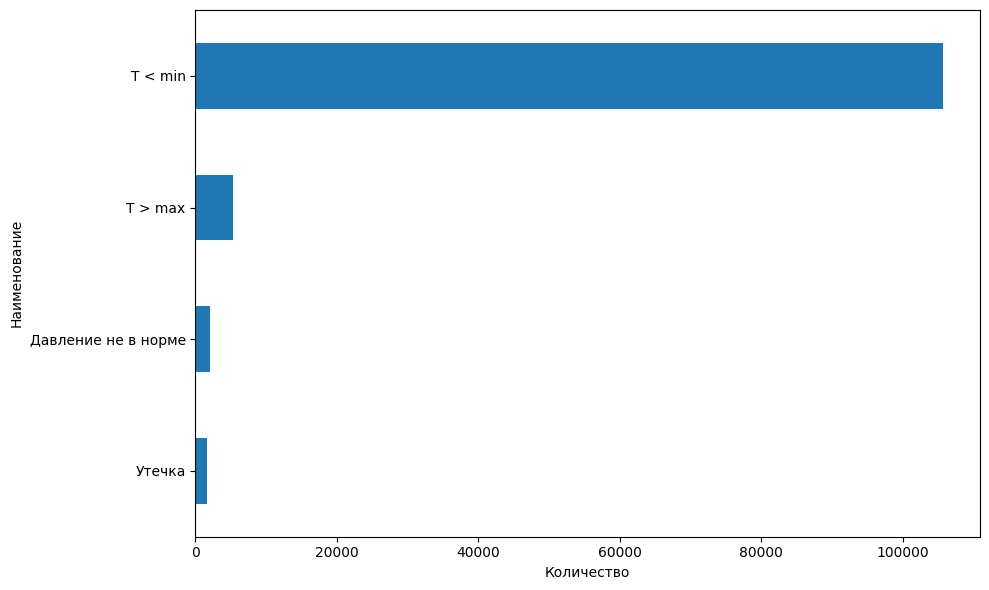

In [299]:
plot_gist_categorical(events, 'Наименование')

In [119]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114609 entries, 0 to 114608
Data columns (total 11 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   Наименование                                        114609 non-null  object        
 1   Источник                                            114609 non-null  object        
 2   Дата создания во внешней системе                    114609 non-null  datetime64[ns]
 3   Дата закрытия                                       114010 non-null  object        
 4   Округ                                               114609 non-null  object        
 5   УНОМ                                                114609 non-null  float64       
 6   Адрес                                               114609 non-null  object        
 7   Дата и время завершения события                     74494 non-null   object        

In [23]:
events = events[['Наименование', 'Источник', 'Дата создания во внешней системе', 'УНОМ', 'month', 'day']]
events

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1
...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2115890.0,5,14
114605,T < min,EDC,2024-05-14 22:06:03,22771.0,5,14
114606,T < min,EDC,2024-05-14 22:15:38,1264.0,5,14
114607,T < min,EDC,2024-05-14 22:15:58,14250.0,5,14


In [24]:
def make_random_sample(events, row):
    """Создает случайный сэмпл для класса ОК (событие, когда ничего не произошло).

    Аргументы:
        events (pd.DataFrame): DataFrame с событиями.
        row (pd.Series): Строка данных, для которой создается случайный сэмпл.

    Возвращает:
        pd.Series: Обновленная строка с измененными датой и дополнительными полями.
    """
    new_day = row['day']
    new_month = row['month']
    e = events[events['УНОМ'] == row['УНОМ']]
    n = len(e)
    if n < 100:
        while ((e[['УНОМ', 'month', 'day']] == pd.Series(row[['УНОМ', 'month', 'day']])).all(axis=1)).any():
            new_month = random.choice([10, 11, 12, 1, 2, 3, 4])
            new_day = random.randint(1, 28)
            row['month'] = new_month
            row['day'] = new_day
        if new_month < 10:
            row['Дата создания во внешней системе'] = row['Дата создания во внешней системе'].replace(year=2024, day=new_day, month=new_month)
        else:
            row['Дата создания во внешней системе'] = row['Дата создания во внешней системе'].replace(year=2023, day=new_day, month=new_month)

    
    row['Наименование'] = None
    row['Источник'] = None
    
    return row

In [223]:
events

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1
...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2115890.0,5,14
114605,T < min,EDC,2024-05-14 22:06:03,22771.0,5,14
114606,T < min,EDC,2024-05-14 22:15:38,1264.0,5,14
114607,T < min,EDC,2024-05-14 22:15:58,14250.0,5,14


In [25]:
def make_dataset(events):
    """Добавляет в DataFrame рандомные события с классом ОК.

    Аргументы:
        events (pd.DataFrame): Исходный DataFrame с событиями.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными случайными событиями класса ОК.
    """
    n = len(events)
    for i, row in events.iterrows():
        new_row = make_random_sample(events, row)
        events = pd.concat((events, pd.DataFrame([new_row])), ignore_index=True)
        if (i%1000 == 0): print(i)
    return events

dataset = make_dataset(events)
dataset
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000


,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1
...,...,...,...,...,...,...
229213,None,None,2024-05-14 22:04:07,2115890.0,5,14
229214,None,None,2024-02-24 22:06:03,22771.0,2,24
229215,None,None,2024-02-06 22:15:38,1264.0,2,6
229216,None,None,2024-05-14 22:15:58,14250.0,5,14


Готовый датасет для событий, далее будем добавлять агрегированные признаки из других источников

In [26]:
dataset['Наименование'] = dataset['Наименование'].fillna('ОК')
dataset

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1
...,...,...,...,...,...,...
229213,ОК,None,2024-05-14 22:04:07,2115890.0,5,14
229214,ОК,None,2024-02-24 22:06:03,22771.0,2,24
229215,ОК,None,2024-02-06 22:15:38,1264.0,2,6
229216,ОК,None,2024-05-14 22:15:58,14250.0,5,14


In [27]:
odpu['Объём поданого теплоносителя в систему ЦО'] = odpu['Объём поданого теплоносителя в систему ЦО'].astype(float)
odpu['volume1forhour'] = odpu['Объём поданого теплоносителя в систему ЦО'] / (odpu['Наработка часов счётчика'])
odpu['volume2forhour'] = odpu['Объём обратного теплоносителя из системы ЦО'] / (odpu['Наработка часов счётчика'])
odpu['q2forhour'] = odpu['Расход тепловой энергии '].astype(float) / (odpu['Наработка часов счётчика'])
odpu['Месяц/Год'] = pd.to_datetime(odpu['Месяц/Год'], format='%d-%m-%Y')
odpu

,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,UNOM,Адрес,Центральное отопление(контур),Марка счетчика,...,Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки,Марка счетчика,volume1forhour,volume2forhour,q2forhour
0,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,NaN,22.447302,25.240633,24.000000,0,NaN,NaN,0.0,0.0,0.0
1,697394818,699114980,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,80046,"ул. Николая Старостина, д. 15",ЦО1,АТ-Т-2,...,NaN,24.4263,24.377792,0.000000,0,D,NaN,NaN,NaN,NaN
2,697002010,698455623,ВАО,Богородское,"ООО ""УО АЛЬЗА""",МКД,20118,"Погонный пр., д. 1, к. 5",ЦО1,АТ-Т-2,...,NaN,25.203604,23.814062,24.000000,0,NaN,NaN,0.0,0.0,0.0
3,696640064,698454009,ВАО,Соколиная Гора,"ООО ""УК М. Р-Н ""СОКОЛИНАЯ ГОРА""",МКД,24167,"8-я ул. Соколиной Горы, д. 4",ЦО1,ВКТ-7,...,NaN,22.81,24.02,24.000000,0,NaN,NaN,0.0,0.0,0.0
4,866892,866931,ВАО,Новогиреево,ГБОУ Школа № 1798,Бюджет,2504320,"Зелёный пр-т, д. 75, стр. 3",ЦО1,ВИС.Т,...,NaN,32.208333,32.454167,0.000000,0,g,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004370,382835933,383183358,ВАО,Соколиная Гора,"ООО ""УК М. Р-Н ""СОКОЛИНАЯ ГОРА""",МКД,2999,"Буракова ул., д. 11, к. 1",ЦО1,КМ-5-2,...,NaN,22.562134,23.573563,24.000000,0,NaN,NaN,0.0,0.0,0.0
1004371,382812953,382917759,ВАО,Перово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ПЕРОВО""",МКД,19472,"Перовская ул., д. 40, к. 4",ЦО1,КМ-5-2,...,NaN,19.936941,19.415073,24.000000,0,NaN,NaN,0.0,0.0,0.0
1004372,382696196,382831154,ВАО,Северное Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА СЕВЕРНОЕ ИЗМАЙЛОВО""",МКД,18761,"9-я Парковая ул., д. 61, к. 2",ЦО1,КМ-5-2,...,NaN,20,1,0.000000,0,NaN,NaN,NaN,NaN,NaN
1004373,383731553,384508438,ВАО,Северное Измайлово,"ГБУ ""ЖИЛИЩНИК РАЙОНА СЕВЕРНОЕ ИЗМАЙЛОВО""",МКД,18695,"7-я Парковая ул., д. 33, к. 1",ЦО1,КМ-5-2,...,NaN,20.751284,20.647778,0.000000,0,NaN,NaN,NaN,NaN,NaN


In [305]:
odpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004375 entries, 0 to 1004374
Data columns (total 27 columns):
 #   Column                                       Non-Null Count    Dtype         
---  ------                                       --------------    -----         
 0   ID УУ                                        1004375 non-null  int64         
 1   ID ТУ                                        1004375 non-null  int64         
 2   Округ                                        1004375 non-null  object        
 3   Район                                        1004375 non-null  object        
 4   Потребители                                  1004375 non-null  object        
 5   Группа                                       1004375 non-null  object        
 6   UNOM                                         1004375 non-null  int64         
 7   Адрес                                        1004375 non-null  object        
 8   Центральное отопление(контур)                1004375

In [310]:
row

Наименование                                    T < min
Источник                                            EDC
Дата создания во внешней системе    2023-01-06 00:58:29
УНОМ                                            10013.0
month                                                 1
day                                                   6
Name: 0, dtype: object

In [28]:
ftrs2odpu = [
    'mean_volume1forhour',
    'std_volume1forhour',
    'mean_volume2forhour',
    'std_volume2forhour',
    'mean_q2forhour',
    'std_q2forhour',
    'min_volume1forhour',
    'max_volume1forhour',
    'median_volume1forhour',
    'min_volume2forhour',
    'max_volume2forhour',
    'median_volume2forhour',
    'min_q2forhour',
    'max_q2forhour',
    'median_q2forhour',
    'Потребители',
    'Группа',
    'Центральное отопление(контур)',
    'Ошибки'
]
def add_opdu_features(odpu, row):
    """Добавляет дополнительные фичи из таблицы ОДПУ к сэмплу.

    Аргументы:
        odpu (pd.DataFrame): DataFrame с данными ОДПУ.
        row (pd.Series): Строка данных, к которой добавляются новые фичи.

    Возвращает:
        pd.Series: Обновленная строка с добавленными фичами из таблицы ОДПУ.
    """
    
    local_odpu = odpu[odpu['UNOM'] == row['УНОМ']]
    curr_time = row['Дата создания во внешней системе']
    local_odpu = local_odpu[local_odpu['Месяц/Год'] < curr_time]
    if len(local_odpu) > 14:
        local_odpu = local_odpu.iloc[-14:]

    for feature in ['volume1forhour', 'volume2forhour', 'q2forhour']:
        row[f'mean_{feature}'] = local_odpu[feature].mean()
        row[f'std_{feature}'] = local_odpu[feature].std()
        row[f'min_{feature}'] = local_odpu[feature].min()
        row[f'max_{feature}'] = local_odpu[feature].max()
        row[f'median_{feature}'] = local_odpu[feature].median()
    if len(local_odpu) > 0:
        row['Потребители'] = local_odpu['Потребители'].iloc[-1]
        row['Группа'] = local_odpu['Группа'].iloc[-1]
        row['Центральное отопление(контур)'] = local_odpu['Центральное отопление(контур)'].iloc[-1]
        row['Ошибки'] = local_odpu['Ошибки'].iloc[-1]
    else:
        row['Потребители'] = None
        row['Группа'] = None
        row['Центральное отопление(контур)'] = None
        row['Ошибки'] = None
    return row[ftrs2odpu]
    

Погода с октября по апрель, предварительно взятая из API внешнего сервиса

In [29]:
with open('weather.json', 'r', encoding='utf-8') as file:
    weather = json.load(file)
weather

{'october': {'01': ['+16', '+14'],
  '02': ['+13', '+9'],
  '03': ['+15', '+9'],
  '04': ['+16', '+13'],
  '05': ['+14', '+9'],
  '06': ['+11', '+10'],
  '07': ['+6', '+2'],
  '08': ['+3', '+5'],
  '09': ['+4', '+2'],
  '10': ['+4', '+2'],
  '11': ['+7', '0'],
  '12': ['+11', '+6'],
  '13': ['+12', '+9'],
  '14': ['+12', '+6'],
  '15': ['+11', '+13'],
  '16': ['+7', '+7'],
  '17': ['+5', '+4'],
  '18': ['+6', '+4'],
  '19': ['+6', '+5'],
  '20': ['+5', '+4'],
  '21': ['+4', '+3'],
  '22': ['+4', '0'],
  '23': ['+6', '+3'],
  '24': ['+2', '+2'],
  '25': ['+1', '-1'],
  '26': ['0', '-2'],
  '27': ['-1', '-2'],
  '28': ['0', '-1'],
  '29': ['+1', '0'],
  '30': ['+2', '0'],
  '31': ['+10', '+7']},
 'november': {'01': ['+15', '+9'],
  '02': ['+6', '+11'],
  '03': ['+5', '+2'],
  '04': ['+5', '+1'],
  '05': ['+11', '+8'],
  '06': ['+10', '+9'],
  '07': ['+10', '+9'],
  '08': ['+9', '+8'],
  '09': ['+7', '+5'],
  '10': ['+7', '+5'],
  '11': ['+7', '+4'],
  '12': ['+4', '+4'],
  '13': ['+4', '

In [30]:
num2month = {
    10: "october",
    11: "november",
    12: "december",
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september"
}

def collect_weather(row, weather):
    """Добавляет информацию о погоде к строке данных.

    Аргументы:
        row (pd.Series): Строка данных, к которой добавляется информация о погоде.
        weather (dict): Словарь с данными о погоде, где ключи - месяцы, а значения - словари с днями и погодными данными.

    Возвращает:
        pd.Series: Обновленная строка с добавленными данными о погоде.
    """
    
    mon = num2month[row.month]
    day = "{:02d}".format(row.day)
    row['weather1'], row['weather2'] = weather[mon][day]
    return row[['weather1', 'weather2']]

In [31]:
new_event_names = [
    'Давление не в норме',
    'T < min',
    'T > max',
    'Утечка'
]

In [32]:
events

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1
...,...,...,...,...,...,...
114604,Давление не в норме,ASUPR,2024-05-14 22:04:07,2115890.0,5,14
114605,T < min,EDC,2024-05-14 22:06:03,22771.0,5,14
114606,T < min,EDC,2024-05-14 22:15:38,1264.0,5,14
114607,T < min,EDC,2024-05-14 22:15:58,14250.0,5,14


In [46]:
feature2events = [
    'Давление не в норме_count', 
    'T < min_count', 
    'T > max_count', 
    'Утечка_count', 
    'month1_count', 
    'month2_count', 
    'month3_count', 
    'month4_count', 
    'month10_count', 
    'month11_count', 
    'month12_count'
]

def collect_events(row, events):
    """Добавляет информацию о событиях к строке данных.

    Аргументы:
        row (pd.Series): Строка данных, к которой добавляется информация о событиях.
        events (pd.DataFrame): DataFrame с данными о событиях.

    Возвращает:
        pd.Series: Обновленная строка с добавленными данными о событиях.
    """
    
    local_events = events[events['УНОМ'] == row['УНОМ']]
    curr_time = row['Дата создания во внешней системе']
    local_events = local_events[local_events['Дата создания во внешней системе'] > curr_time]
    grpb = local_events.groupby('Наименование').count()['УНОМ']
    for event_type in new_event_names:
        if event_type in grpb:
            row[f'{event_type}_count'] = grpb[event_type]
        else:
            row[f'{event_type}_count'] = 0

    grpb = local_events.groupby('month').count()['Наименование']
    for month_num in [1,2,3,4,10,11,12]:
        if month_num in grpb:
            row[f"month{month_num}_count"] = grpb[month_num]
        else:
            row[f"month{month_num}_count"] = 0
    
    return row[feature2events]

# collect_events(row, events)

In [47]:
def collect_dataset(dataset, odpu, weather, events):
    """Собирает итоговый датасет с добавлением всех признаков.

    Аргументы:
        dataset (pd.DataFrame): Исходный DataFrame для добавления признаков.
        odpu (pd.DataFrame): DataFrame с данными ОДПУ.
        weather (dict): Словарь с данными о погоде, где ключи - месяцы, а значения - словари с днями и погодными данными.
        events (pd.DataFrame): DataFrame с данными о событиях.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными признаками ОДПУ, погодными данными и данными о событиях.
    """
    
    dataset[ftrs2odpu] = dataset.apply(lambda x: add_opdu_features(odpu, x), axis=1)
    dataset[['weather1', 'weather2']] = dataset.apply(lambda x: collect_weather(x, weather), axis=1)
    dataset[feature2events] = dataset.apply(lambda x: collect_events(x, events), axis=1)
    return dataset

In [48]:
dataset = dataset[dataset.month!=5]
dataset

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,...,T < min_count,T > max_count,Утечка_count,month1_count,month2_count,month3_count,month4_count,month10_count,month11_count,month12_count
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6,NaN,NaN,NaN,NaN,...,190.0,4.0,1.0,8.0,12.0,2.0,6.0,137.0,14.0,13.0
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12,NaN,NaN,NaN,NaN,...,43.0,3.0,NaN,NaN,3.0,2.0,NaN,37.0,NaN,3.0
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,110.0,1.0,14.0,9.0,8.0,4.0,2.0,68.0,11.0,14.0
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,109.0,1.0,14.0,9.0,8.0,4.0,2.0,67.0,11.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229206,ОК,None,2023-11-17 20:28:03,30153.0,11,17,8.996873,0.088717,8.985886,0.088830,...,30.0,NaN,NaN,11.0,NaN,NaN,10.0,NaN,1.0,7.0
229210,ОК,None,2024-02-17 21:25:17,4096.0,2,17,20.784732,0.067964,20.768528,0.068387,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229214,ОК,None,2024-02-24 22:06:03,22771.0,2,24,12.407459,0.344867,12.704706,0.354912,...,8.0,NaN,NaN,NaN,NaN,6.0,1.0,NaN,NaN,NaN
229215,ОК,None,2024-02-06 22:15:38,1264.0,2,6,13.273749,0.335651,13.194042,0.221213,...,5.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN


In [49]:
%%time

data = collect_dataset(dataset, odpu, weather, events)
data

odpu ok
weather ok
CPU times: user 30min 43s, sys: 33.3 s, total: 31min 17s
Wall time: 22min 14s


,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,...,T < min_count,T > max_count,Утечка_count,month1_count,month2_count,month3_count,month4_count,month10_count,month11_count,month12_count
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6,NaN,NaN,NaN,NaN,...,190,4,1,8,12,2,6,137,14,13
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28,NaN,NaN,NaN,NaN,...,8,0,0,0,0,0,0,8,0,0
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12,NaN,NaN,NaN,NaN,...,43,3,0,0,3,2,0,37,0,3
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,110,1,14,9,8,4,2,68,11,14
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,109,1,14,9,8,4,2,67,11,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229206,ОК,None,2023-11-17 20:28:03,30153.0,11,17,8.996873,0.088717,8.985886,0.088830,...,30,0,0,11,0,0,10,0,1,7
229210,ОК,None,2024-02-17 21:25:17,4096.0,2,17,20.784732,0.067964,20.768528,0.068387,...,7,0,0,0,0,0,0,0,0,0
229214,ОК,None,2024-02-24 22:06:03,22771.0,2,24,12.407459,0.344867,12.704706,0.354912,...,8,0,0,0,0,6,1,0,0,0
229215,ОК,None,2024-02-06 22:15:38,1264.0,2,6,13.273749,0.335651,13.194042,0.221213,...,5,1,0,0,0,2,1,0,0,0


In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223386 entries, 0 to 223385
Data columns (total 70 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Наименование                         223386 non-null  object        
 1   Дата создания во внешней системе     223386 non-null  datetime64[ns]
 2   УНОМ                                 223386 non-null  float64       
 3   month                                223386 non-null  int64         
 4   mean_volume1forhour                  207034 non-null  float64       
 5   std_volume1forhour                   205296 non-null  float64       
 6   mean_volume2forhour                  207034 non-null  float64       
 7   std_volume2forhour                   205296 non-null  float64       
 8   mean_q2forhour                       206998 non-null  float64       
 9   std_q2forhour                        205261 non-null  float64       
 

In [50]:
df['УНОМ'] = df['unom']

Добавляем статические фичи для каждого УНОМа

In [51]:
df['УНОМ'] = df['unom']
data = data.merge(df, how='left', on='УНОМ')
data

,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,...,NDOC,DDOC,ADR_TYPE,VID,SOSTAD,STATUS,geoData,geodata_center,ID ODS,PHONE_NUMBER
0,T < min,EDC,2023-01-06 00:58:29,10013.0,1,6,NaN,NaN,NaN,NaN,...,875-В-РП,28.07.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.823055979, 55.743409092], [...","{coordinates=[37.824130515, 55.743739433], typ...",143494928.0,8 (495) 539-53-53
1,T < min,EDC,2023-01-28 20:03:12,260116.0,1,28,NaN,NaN,NaN,NaN,...,356-В-РП,03.09.2014,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.810376823, 55.81022121], [3...","{coordinates=[37.810677847, 55.810132692], typ...",NaN,NaN
2,T < min,EDC,2023-03-12 09:00:50,13967.0,3,12,NaN,NaN,NaN,NaN,...,781-В-РП,31.07.2003,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.754590479, 55.746079537], [...","{coordinates=[37.754713792, 55.746143448], typ...",143495637.0,8 (495) 539-53-53
3,T < min,EDC,2023-10-01 05:41:02,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,875-В-РП,28.07.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.833901142, 55.757964361], [...","{coordinates=[37.835401766, 55.757885407], typ...",143495703.0,8 (495) 539-53-53
4,T < min,EDC,2023-10-01 05:41:14,15109.0,10,1,0.000000,NaN,0.000000,NaN,...,875-В-РП,28.07.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.833901142, 55.757964361], [...","{coordinates=[37.835401766, 55.757885407], typ...",143495703.0,8 (495) 539-53-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223381,ОК,None,2023-11-17 20:28:03,30153.0,11,17,8.996873,0.088717,8.985886,0.088830,...,1201-В-РП,16.09.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.790008267, 55.76534135], [3...","{coordinates=[37.789802238, 55.765162077], typ...",143495356.0,8 (495) 539-53-53
223382,ОК,None,2024-02-17 21:25:17,4096.0,2,17,20.784732,0.067964,20.768528,0.068387,...,1294-В-РП,29.09.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.788024404, 55.744132711], [...","{coordinates=[37.788260657, 55.744050285], typ...",143495457.0,8 (495) 539-53-53
223383,ОК,None,2024-02-24 22:06:03,22771.0,2,24,12.407459,0.344867,12.704706,0.354912,...,875-В-РП,28.07.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.835380384, 55.768036571], [...","{coordinates=[37.835513967, 55.768159399], typ...",143495538.0,8 (495) 539-53-53
223384,ОК,None,2024-02-06 22:15:38,1264.0,2,6,13.273749,0.335651,13.194042,0.221213,...,29-В-РП,19.01.2004,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.822159833, 55.81693786], [3...","{coordinates=[37.823751924, 55.816962248], typ...",143495132.0,8 (495) 539-53-53


In [55]:
data.columns.tolist()

['Наименование',
 'Источник',
 'Дата создания во внешней системе',
 'УНОМ',
 'month',
 'day',
 'mean_volume1forhour',
 'std_volume1forhour',
 'mean_volume2forhour',
 'std_volume2forhour',
 'mean_q2forhour',
 'std_q2forhour',
 'min_volume1forhour',
 'max_volume1forhour',
 'median_volume1forhour',
 'min_volume2forhour',
 'max_volume2forhour',
 'median_volume2forhour',
 'min_q2forhour',
 'max_q2forhour',
 'median_q2forhour',
 'Потребители_x',
 'Группа_x',
 'Центральное отопление(контур)_x',
 'Ошибки',
 'weather1',
 'weather2',
 'Давление не в норме_count',
 'T < min_count',
 'T > max_count',
 'Утечка_count',
 'month1_count',
 'month2_count',
 'month3_count',
 'month4_count',
 'month10_count',
 'month11_count',
 'month12_count',
 'Адрес из сторонней системы',
 'Идентификатор из сторонней системы',
 'Адрес по БТИ',
 'unom',
 'Округ',
 'Район',
 'Серии проектов',
 'Количество этажей',
 'Количество подъездов',
 'Количество квартир',
 'Общая площадь',
 'Общая площадь жилых помещений',
 'Общая 

Оставляем только часть фичей для обучения

In [56]:
features = ['Наименование',
 # 'Источник',
 'Дата создания во внешней системе',
 'УНОМ',
 'month',
 # 'day',
 'mean_volume1forhour',
 'std_volume1forhour',
 'mean_volume2forhour',
 'std_volume2forhour',
 'mean_q2forhour',
 'std_q2forhour',
 'min_volume1forhour',
 'max_volume1forhour',
 'median_volume1forhour',
 'min_volume2forhour',
 'max_volume2forhour',
 'median_volume2forhour',
 'min_q2forhour',
 'max_q2forhour',
 'median_q2forhour',
 'Потребители_x',
 'Группа_x',
 'Центральное отопление(контур)_x',
 'Ошибки',
 'weather1',
 'weather2',
 # 'Адрес из сторонней системы',
 # 'Идентификатор из сторонней системы',
 # 'Адрес по БТИ',
 # 'unom',
 'Округ',
 'Район',
 'Серии проектов',
 'Количество этажей',
 'Количество подъездов',
 'Количество квартир',
 'Общая площадь',
 'Общая площадь жилых помещений',
 # 'Общая площадь нежилых помещений',
 'Износ объекта (по БТИ)',
 'Материалы стен',
 'Признак аварийности здания',
 'Количество пассажирских лифтов',
 'Количество грузопассажирских лифтов',
 # 'Очередность уборки кровли',
 'Материалы кровли по БТИ',
 'Типы жилищного фонда',
 'Статусы МКД',
 # 'Потребители_y',
 # 'Группа_y',
 # 'Центральное отопление(контур)_y',
 'Марка счетчика ',
 # 'Серия/Номер счетчика',
 # 'ID УУ',
 # 'Полный адрес',
 # '№ ОДС',
 # 'Адрес ОДС',
 'ЦТП',
 # '№ п/п',
 # 'Город',
 # 'Административный округ',
 'Муниципальный округ',
 # 'Населенный пункт',
 # 'Улица',
 # 'Тип номера дом',
 # 'Номер дома',
 # 'Номер корпуса',
 # 'Тип номера строения/сооружения',
 # 'Номер строения',
 # 'UNAD',
 'Материал',
 'Назначение',
 'Класс',
 'Тип',
 # 'Признак',
 # 'global_id',
 'OBJ_TYPE',
 # 'ADDRESS_x',
 # 'Муниципальный округ.1',
 # 'Наименование элемента планировочной структуры или улично-дорожной сети',
 # 'Тип номера дома, владения, участка',
 'Внутригородская территория',
 # 'ADM_AREA',
 # 'DISTRICT',
 # 'NREG',
 # 'DREG',
 # 'N_FIAS',
 # 'D_FIAS',
 # 'KAD_N',
 # 'KAD_ZU',
 # 'KLADR',
 # 'TDOC',
 # 'NDOC',
 # 'DDOC',
 # 'ADR_TYPE',
 # 'VID',
 # 'SOSTAD',
 # 'STATUS',
 # 'geoData',
 # 'geodata_center',
 # 'ID ODS',
 # 'PHONE_NUMBER'
'Давление не в норме_count',
 'T < min_count',
 'T > max_count',
 'Утечка_count',
 'month1_count',
 'month2_count',
 'month3_count',
 'month4_count',
 'month10_count',
 'month11_count',
 'month12_count',
           ]
            
data['Дата создания во внешней системе'] = pd.to_datetime(data['Дата создания во внешней системе'])

In [57]:
data = data[features]
data

,Наименование,Дата создания во внешней системе,УНОМ,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,...,T < min_count,T > max_count,Утечка_count,month1_count,month2_count,month3_count,month4_count,month10_count,month11_count,month12_count
0,T < min,2023-01-06 00:58:29,10013.0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,190,4,1,8,12,2,6,137,14,13
1,T < min,2023-01-28 20:03:12,260116.0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,8,0,0,0,0,0,0,8,0,0
2,T < min,2023-03-12 09:00:50,13967.0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,43,3,0,0,3,2,0,37,0,3
3,T < min,2023-10-01 05:41:02,15109.0,10,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,110,1,14,9,8,4,2,68,11,14
4,T < min,2023-10-01 05:41:14,15109.0,10,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,109,1,14,9,8,4,2,67,11,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223381,ОК,2023-11-17 20:28:03,30153.0,11,8.996873,0.088717,8.985886,0.088830,0.109304,0.021200,...,30,0,0,11,0,0,10,0,1,7
223382,ОК,2024-02-17 21:25:17,4096.0,2,20.784732,0.067964,20.768528,0.068387,0.152859,0.021256,...,7,0,0,0,0,0,0,0,0,0
223383,ОК,2024-02-24 22:06:03,22771.0,2,12.407459,0.344867,12.704706,0.354912,0.167270,0.025005,...,8,0,0,0,0,6,1,0,0,0
223384,ОК,2024-02-06 22:15:38,1264.0,2,13.273749,0.335651,13.194042,0.221213,0.519687,0.002097,...,5,1,0,0,0,2,1,0,0,0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223386 entries, 0 to 223385
Data columns (total 61 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Наименование                         223386 non-null  object        
 1   Дата создания во внешней системе     223386 non-null  datetime64[ns]
 2   УНОМ                                 223386 non-null  float64       
 3   month                                223386 non-null  int64         
 4   mean_volume1forhour                  207298 non-null  float64       
 5   std_volume1forhour                   195037 non-null  float64       
 6   mean_volume2forhour                  207031 non-null  float64       
 7   std_volume2forhour                   194702 non-null  float64       
 8   mean_q2forhour                       206585 non-null  float64       
 9   std_q2forhour                        204670 non-null  float64       
 

In [59]:
def extract_datetime_features(df, date_col):
    """Извлекает временные признаки из столбца с датами.

    Аргументы:
        df (pd.DataFrame): DataFrame, содержащий данные.
        date_col (str): Название столбца с датами.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными временными признаками.
    """
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekofyear'] = df[date_col].dt.isocalendar().week
    df['quarter'] = df[date_col].dt.quarter
    df['is_month_start'] = df[date_col].dt.is_month_start
    df['is_month_end'] = df[date_col].dt.is_month_end
    return df

def add_cyclic_features(df, col, max_val):
    """Добавляет циклические признаки в DataFrame.

    Аргументы:
        df (pd.DataFrame): DataFrame, содержащий данные.
        col (str): Название столбца, для которого добавляются циклические признаки.
        max_val (int): Максимальное значение для нормализации циклического признака.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными циклическими признаками.
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df


data = extract_datetime_features(data, "Дата создания во внешней системе")
data = add_cyclic_features(data, 'month', 12)
data = add_cyclic_features(data, 'hour', 24)
data = add_cyclic_features(data, 'quarter', 4)
data = add_cyclic_features(data, 'day', 31)
data = add_cyclic_features(data, 'dayofweek', 31)
data = add_cyclic_features(data, 'weekofyear', 31)

In [72]:
new_column_names = {
    'Потребители_x': 'Потребители',
     'Группа_x': 'Группа',
     'Центральное отопление(контур)_x': 'Центральное отопление(контур)',
}

# Переименование столбцов
data.rename(columns=new_column_names, inplace=True)

Разделяем тренировочные и валидационные данные по временном признаку. train - до 1 марта, test - после 1 марта 

In [ ]:
train = data[(data['Дата создания во внешней системе'] <= datetime.datetime(2024, 3, 1)) &
                        (data['Дата создания во внешней системе'] >= datetime.datetime(2023, 10, 15))]
train

In [74]:
test = data[(data['Дата создания во внешней системе'] <= datetime.datetime(2024, 4, 30)) &
                        (data['Дата создания во внешней системе'] > datetime.datetime(2024, 3, 1))]
test

,Наименование,Дата создания во внешней системе,УНОМ,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,...,hour_sin,hour_cos,quarter_sin,quarter_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos
103468,T < min,2024-03-01 00:12:10,18922.0,3,20.091815,0.012348,19.980655,0.015049,0.403307,0.056721,...,0.000000,1.000000e+00,1.000000e+00,6.123234e-17,0.201299,0.979530,0.724793,0.688967,0.968077,-0.250653
103469,T > max,2024-03-01 01:23:36,18625.0,3,4.219958,0.074434,4.209423,0.074122,0.169427,0.013037,...,0.258819,9.659258e-01,1.000000e+00,6.123234e-17,0.201299,0.979530,0.724793,0.688967,0.968077,-0.250653
103470,T < min,2024-03-01 02:03:48,2135060.0,3,11.878682,0.133807,12.135143,0.137012,0.063738,0.016372,...,0.500000,8.660254e-01,1.000000e+00,6.123234e-17,0.201299,0.979530,0.724793,0.688967,0.968077,-0.250653
103471,T < min,2024-03-01 04:23:50,2102443.0,3,5.329452,0.034911,5.231469,0.034817,0.029520,0.003910,...,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,0.201299,0.979530,0.724793,0.688967,0.968077,-0.250653
103472,T < min,2024-03-01 05:13:40,28626.0,3,11.031512,7.206958,10.961083,7.177866,0.109385,0.088761,...,0.965926,2.588190e-01,1.000000e+00,6.123234e-17,0.201299,0.979530,0.724793,0.688967,0.968077,-0.250653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223365,ОК,2024-04-03 17:33:17,23800.0,4,4.131366,0.173221,4.204706,0.176751,0.123657,0.013322,...,-0.965926,-2.588190e-01,1.224647e-16,-1.000000e+00,0.571268,0.820763,0.394356,0.918958,0.299363,-0.954139
223373,ОК,2024-04-23 18:35:32,18151.0,4,4.227235,0.045956,4.259607,0.046691,0.086759,0.001397,...,-1.000000,-1.836970e-16,1.224647e-16,-1.000000e+00,-0.998717,-0.050649,0.201299,0.979530,-0.299363,-0.954139
223375,ОК,2024-03-07 19:27:42,18979.0,3,4.184916,0.144165,4.213177,0.145546,0.134334,0.012698,...,-0.965926,2.588190e-01,1.000000e+00,6.123234e-17,0.988468,0.151428,0.571268,0.820763,0.897805,-0.440394
223376,ОК,2024-03-04 19:37:56,27135.0,3,5.434729,0.306268,5.417313,0.305700,0.139931,0.012440,...,-0.965926,2.588190e-01,1.000000e+00,6.123234e-17,0.724793,0.688967,0.000000,1.000000,0.897805,-0.440394


In [75]:
train.drop("Дата создания во внешней системе", axis=1, inplace=True)
test.drop("Дата создания во внешней системе", axis=1, inplace=True)

In [76]:
train

,Наименование,УНОМ,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,min_volume1forhour,...,hour_sin,hour_cos,quarter_sin,quarter_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos
36922,T < min,13846.0,10,inf,NaN,inf,NaN,0.059625,0.020963,5.645662,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36923,T < min,64063.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36924,T < min,8728.0,10,12.867362,0.353951,12.988038,0.346932,0.088852,0.036559,12.175781,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36925,T < min,2300.0,10,2.116510,0.069923,1.892678,0.315688,0.043535,0.017969,1.990254,...,0.258819,0.965926,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36926,Давление не в норме,2115890.0,10,2.709189,2.221742,2.886151,1.897232,0.044397,0.025656,0.231181,...,0.500000,0.866025,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223380,ОК,61193.0,1,29.482381,2.062329,29.331042,2.070847,0.759625,0.073934,26.081250,...,-0.965926,0.258819,1.000000e+00,6.123234e-17,0.299363,-0.954139,0.937752,0.347305,0.394356,0.918958
223381,ОК,30153.0,11,8.996873,0.088717,8.985886,0.088830,0.109304,0.021200,8.902100,...,-0.866025,0.500000,-2.449294e-16,1.000000e+00,-0.299363,-0.954139,0.724793,0.688967,0.101168,-0.994869
223382,ОК,4096.0,2,20.784732,0.067964,20.768528,0.068387,0.152859,0.021256,20.676432,...,-0.707107,0.707107,1.000000e+00,6.123234e-17,-0.299363,-0.954139,0.848644,0.528964,0.988468,0.151428
223383,ОК,22771.0,2,12.407459,0.344867,12.704706,0.354912,0.167270,0.025005,11.990885,...,-0.500000,0.866025,1.000000e+00,6.123234e-17,-0.988468,0.151428,0.848644,0.528964,0.998717,-0.050649


In [77]:
X_train

,УНОМ,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,min_volume1forhour,max_volume1forhour,...,hour_sin,hour_cos,quarter_sin,quarter_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos
36922,13846.0,10,inf,2.445742,inf,3.945725,0.059625,0.020963,5.645662,inf,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36923,64063.0,10,NaN,2.445742,NaN,3.945725,inf,0.045602,NaN,inf,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36924,8728.0,10,12.867362,0.353951,12.988038,0.346932,0.088852,0.036559,12.175781,13.628866,...,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36925,2300.0,10,2.116510,0.069923,1.892678,0.315688,0.043535,0.017969,1.990254,2.193271,...,0.258819,0.965926,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36926,2115890.0,10,2.709189,2.221742,2.886151,1.897232,0.044397,0.025656,0.231181,4.873779,...,0.500000,0.866025,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223380,61193.0,1,29.482381,2.062329,29.331042,2.070847,0.759625,0.073934,26.081250,32.733750,...,-0.965926,0.258819,1.000000e+00,6.123234e-17,0.299363,-0.954139,0.937752,0.347305,0.394356,0.918958
223381,30153.0,11,8.996873,0.088717,8.985886,0.088830,0.109304,0.021200,8.902100,9.090983,...,-0.866025,0.500000,-2.449294e-16,1.000000e+00,-0.299363,-0.954139,0.724793,0.688967,0.101168,-0.994869
223382,4096.0,2,20.784732,0.067964,20.768528,0.068387,0.152859,0.021256,20.676432,20.871663,...,-0.707107,0.707107,1.000000e+00,6.123234e-17,-0.299363,-0.954139,0.848644,0.528964,0.988468,0.151428
223383,22771.0,2,12.407459,0.344867,12.704706,0.354912,0.167270,0.025005,11.990885,12.804688,...,-0.500000,0.866025,1.000000e+00,6.123234e-17,-0.988468,0.151428,0.848644,0.528964,0.998717,-0.050649


In [293]:
X_train.iloc[0, 32]

'22728486.0'

In [294]:
X_train

,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,min_volume1forhour,max_volume1forhour,median_volume1forhour,min_volume2forhour,max_volume2forhour,median_volume2forhour,min_q2forhour,max_q2forhour,median_q2forhour,Потребители_x,Группа_x,Центральное отопление(контур)_x,Ошибки,weather1,weather2,Округ,Район,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Материалы кровли по БТИ,Типы жилищного фонда,Статусы МКД,Марка счетчика,ЦТП,Муниципальный округ,Материал,Назначение,Класс,Тип,OBJ_TYPE,Внутригородская территория,year,day,hour,dayofweek,weekofyear,quarter,is_month_start,is_month_end,month_sin,month_cos,hour_sin,hour_cos,quarter_sin,quarter_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos
36922,10,8.269267,3.741074,7.955086,3.605803,0.059625,0.020963,5.645662,13.818904,6.806250,5.428978,13.304420,6.543473,0.036698,0.081252,0.060275,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОГИРЕЕВО""",МКД,ЦО1,D,11,13,Восточный административный округ,муниципальный округ Новогиреево,П-28,5.000000,3.000000,60.000000,2469.700000,2469.700000,20.998063,кирпичные,22728486.0,0.000000,0.00000,стальная,42875644.0,58761330.0,КМ-5-2,04-04-0224/017,муниципальный округ Новогиреево,кирпичные,многоквартирный дом,жилые,Здание,Здание,внутригородская территория муниципальный округ...,2023,15,0,6,41,4,False,False,-0.866025,0.500000,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36923,10,33.195319,36.301513,76.380592,92.462816,0.228597,0.045883,14.651184,105.537186,23.818078,42.782568,340.583997,44.710014,0.163905,0.302624,0.225413,nan,nan,nan,nan,11,13,Восточный административный округ,муниципальный округ Сокольники,индивидуальный проект,16.000000,2.000000,100.000000,12245.800000,11308.600000,20.998063,монолитные (ж-б),22728486.0,2.000000,2.00000,мягкая-совмещенная с рубероидным покрытием,42875644.0,58761330.0,nan,nan,муниципальный округ Сокольники,монолитные (ж-б),многоквартирный дом,жилые,Здание,Здание,внутригородская территория муниципальный округ...,2023,15,0,6,41,4,False,False,-0.866025,0.500000,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36924,10,12.867362,0.353951,12.988038,0.346932,0.088852,0.036559,12.175781,13.628866,12.899902,12.312012,13.753827,13.028158,0.043098,0.148299,0.075353,"ОАО ""РЭУ-20 Р. ""СОКОЛИНАЯ ГОРА""",МКД,ЦО1,nan,11,13,Восточный административный округ,муниципальный округ Соколиная Гора,П-18/22,12.000000,2.000000,178.000000,7461.700000,7086.200000,20.998063,из железобетонных сегментов,22728486.0,4.000000,0.00000,мягкая-совмещенная с рубероидным покрытием,42875644.0,58761330.0,КМ-5-2,04-02-0422/103,муниципальный округ Соколиная Гора,из железобетонных сегментов,многоквартирный дом,жилые,Здание,Здание,внутригородская территория муниципальный округ...,2023,15,0,6,41,4,False,False,-0.866025,0.500000,0.000000,1.000000,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36925,10,2.116510,0.069923,1.892678,0.315688,0.043535,0.017969,1.990254,2.193271,2.103841,1.396788,2.193727,1.885350,0.019006,0.064886,0.042764,"ГБУ ""ЖИЛИЩНИК РАЙОНА СОКОЛЬНИКИ""",МКД,ЦО1,nan,11,13,Восточный административный округ,муниципальный округ Сокольники,индивидуальный проект,5.000000,4.000000,40.000000,3282.200000,2709.000000,20.998063,кирпичные,22728486.0,4.000000,0.00000,мягкая-совмещенная с рубероидным покрытием,42875644.0,58761330.0,ВИС.Т,04-02-0608/073,муниципальный округ Сокольники,кирпичные,многоквартирный дом,жилые,Здание,Здание,внутригородская территория муниципальный округ...,2023,15,1,6,41,4,False,False,-0.866025,0.500000,0.258819,0.965926,-2.449294e-16,1.000000e+00,0.101168,-0.994869,0.937752,0.347305,0.897805,-0.440394
36926,10,2.709189,2.221742,2

Собираем данные в тип данных catboost.Pool для обучения модели CatBoostClassifier

In [78]:
target_column = 'Наименование'

# Определите список категориальных признаков
categorical_features = [
 'УНОМ',
 'month',
 'Потребители',
 'Группа',
 'Центральное отопление(контур)',
 'Ошибки',
 'Округ',
 'Район',
 'Серии проектов',
 'Материалы стен',
 'Признак аварийности здания',
 'Материалы кровли по БТИ',
 'Типы жилищного фонда',
 'Статусы МКД',
 'Марка счетчика ',
 'ЦТП',
 'Муниципальный округ',
 'Материал',
 'Назначение',
 'Класс',
 'Тип',
 # 'global_id',
 'OBJ_TYPE',
 'Внутригородская территория',
 'is_month_start',
'is_month_end'
           ]

numerical_features = [col for col in train.columns if col not in categorical_features and col != 'Название']

# Удаление строк с NaN в числовых признаках
train[numerical_features] = train[numerical_features].fillna(train[numerical_features].mean())
test[numerical_features] = test[numerical_features].fillna(test[numerical_features].mean())



for col in categorical_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
# Разделите данные на признаки и целевую переменную
X_train = train.drop(columns=[target_column])
y_train = train[target_column]

X_test = test.drop(columns=[target_column])
y_test = test[target_column]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {class_name: weight for class_name, weight in zip(np.unique(y_train), class_weights)}

# Создайте объекты Pool для тренировки и валидации
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

Также, так как мы имеем дисбаланс классов, добавляем веса для каждого события

In [79]:
class_weights_dict

{'T < min': 0.47089930978481526,
 'T > max': 5.496800947867299,
 'Давление не в норме': 23.629711375212224,
 'ОК': 0.38323902358432116,
 'Утечка': 23.35218120805369}

In [80]:
# Создайте и настройте модель CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,         # Количество итераций (увеличьте при необходимости)
    # learning_rate=0.1,       # Скорость обучения
    depth=7,                 # Глубина деревьев
    loss_function='MultiClass', # Функция потерь
    cat_features=categorical_features,
    random_seed=42,
    verbose=100,              # Частота вывода информации о процессе тренировки
    class_weights=class_weights_dict
)

# Обучите модель
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

# Сделайте предсказания на тестовых данных
y_pred = model.predict(X_test)

# Вы можете также получить вероятности
y_pred_proba = model.predict_proba(X_test)

# Оцените качество модели

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Learning rate set to 0.119179
0:	learn: 1.4235215	test: 1.4053507	best: 1.4053507 (0)	total: 617ms	remaining: 10m 16s
100:	learn: 0.5719892	test: 0.6542776	best: 0.6542776 (100)	total: 1m 24s	remaining: 12m 30s
200:	learn: 0.4882680	test: 0.6457227	best: 0.6440927 (194)	total: 2m 50s	remaining: 11m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6440927099
bestIteration = 194

Shrink model to first 195 iterations.
Accuracy: 0.7580811998965606
Classification Report:
                      precision    recall  f1-score   support

            T < min       0.53      0.03      0.05      6127
            T > max       0.52      0.19      0.28       206
Давление не в норме       0.50      0.95      0.66       507
                 ОК       0.79      0.95      0.86     23896
             Утечка       0.07      0.34      0.12       200

           accuracy                           0.76     30936
          macro avg       0.48      0.49      0.39     30936
       weighte

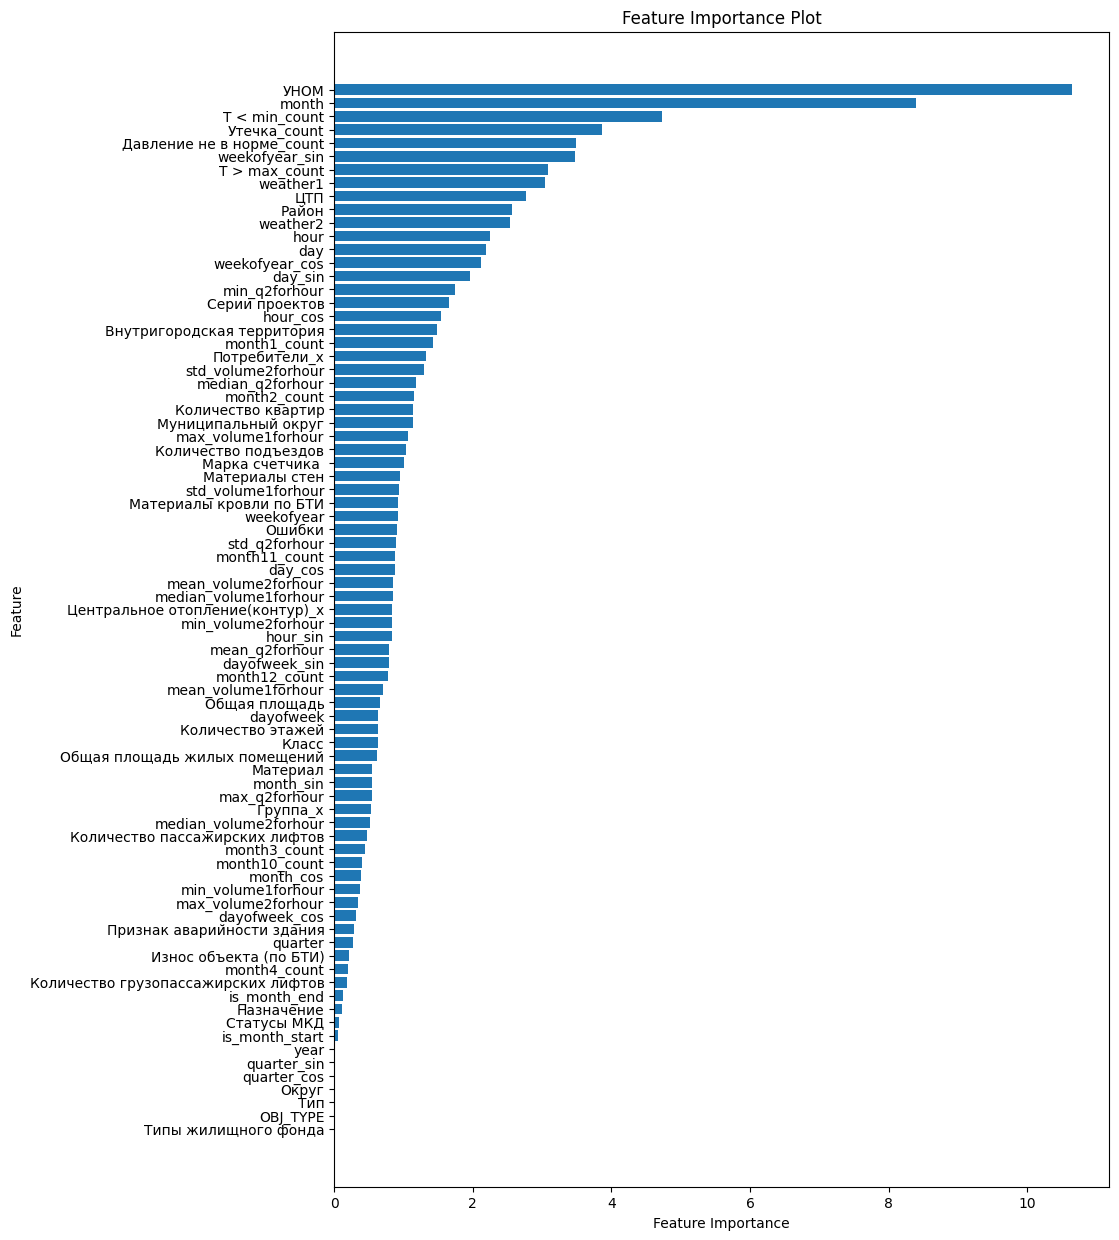

In [67]:
def plot_feature_importance(importances, feature_names):
    """Строит график важности признаков.

    Аргументы:
        importances (array-like): Важность признаков, рассчитанная моделью.
        feature_names (array-like): Список имен признаков.

    Возвращает:
        None: Функция выводит график и не возвращает значение.
    """
    # Создание графика
    plt.figure(figsize=(10, 15))
    
    # Сортировка значений по убыванию важности
    sorted_indices = importances.argsort()[::]
    
    # Расположение признаков по оси X и их важность по оси Y
    plt.barh(range(len(importances)), importances[sorted_indices], align='center')
    
    # Добавление названий признаков к барам
    plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
    
    # Добавление заголовка и меток
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance Plot')
    
    # Показать график
    plt.show()
plot_feature_importance(model.feature_importances_, X_train.columns)

In [81]:
model.save_model("model_task1")